# Pipeline ETL for HubSpot Contacts Object

- **Author:** Richard Stiv Murcia Huerfano
- **Username:** @rich-coding
- **LinkedIn:** [Richard Stiv Murcia Huerfano](https://www.linkedin.com/in/rich-coding/)

In this notebook, I aim to explain a complete pipeline to extract contacts from HubSpot CRM, transform them, and load them back into HubSpot.

The process is divided into three main parts, and a personalized library called `ETLfunctions` has been created in the same directory as the notebook file. The three parts are summarized as follows:

- **Extracting data**:
  - Importing necessary libraries.
  - `collect_all_contacts()` and `collectContacts()`: Both functions generate a "contacts.csv" file in the root directory with raw information from HubSpot.
    - `collect_all_contacts()` collects all contacts in once try and generates one CSV file.
    - `collectContacts()` collects and saves contacts by packages of 100 registers in individual CSV files. This function would be useful if we are working with a big quantity of contacts and we do not want to saturate hardware.

- **Transforming data**:
  - Creating a DataFrame to work with the required fields: This process deletes the previous CSV file and creates a new file called 'all_contacts_fixed.csv.'
  - Applying ETL functions from the `ETLfunctions` library: In this part, data is passed to functions:
    - `countryCity()`
    - `findEmail()`
    - `fixPhoneNumber()`
    - `formatDate()`
    - `duplicatesManagement()`

- **Loading data**:
  - The `uploadContacts()` function was used for this goal.

- **Some Graphics**: In this part, you can find five interactive graphics and one static chart that allows analyzing some distributions of data.

- **Some Things to Improve**: Here, I present two functions that need to be improved.

- **References**: Finally, I present the repositories and files that I used for some parts of this technical test.

## Importing libraries

In [23]:
# Importing libraries
import pandas as pd
import ETLfunctions as ETL
import ast, os, datetime
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

## Fetch all contacts from HubSpot

In [2]:
# FETCH ALL CONTACTS INTO A SINGLE DATAFRAME

# HubSpot API token for authentication
token = "source_token"

# Define parameters for the HubSpot API request
params = {
    "filterGroups": [
        {
            "filters": [
                {
                    "propertyName": "allowed_to_collect",
                    "operator": "EQ",
                    "value": "true",
                }
            ]
        }
    ],
    "properties": [
        "raw_email",
        "country",
        "phone",
        "industry",
        "address",
        "hs_object_id",
        "createdate",
    ],
    "limit": "100",  # Limit the number of records to fetch
}

# Call the collect_all_contacts function to retrieve all contacts and store them in a DataFrame
ETL.collect_all_contacts(token, params)


'Se recolectaron todos los contactos'

### Creating DataFrame with objective fields

In [3]:
# CREATING DATAFRAME WITH OBJECTIVE FIELDS

# File name containing the raw data
filename = 'all_contacts.csv'

# Read the CSV file into a DataFrame using pandas
df_contacts = pd.read_csv(filename)

# Convert strings from the 'properties' field to dictionaries using ast.literal_eval
registers = [ast.literal_eval(register) for register in df_contacts['properties']]

# Convert the list of dictionaries to a new DataFrame
df_contacts = pd.DataFrame(registers)

# Filter and order the fields in the DataFrame
column_names = ["hs_object_id", "raw_email", "address", "country", "phone", "industry", 'createdate']
df_contacts = df_contacts[column_names]

# Rename some columns for clarity
df_contacts.rename(columns={'raw_email': 'email'}, inplace=True)
df_contacts.rename(columns={'industry': 'original_industry'}, inplace=True)

# Remove the processed CSV file
path_old_csv = os.path.join(os.getcwd(), filename)
# Check if the file exists before attempting to delete it
if os.path.exists(filename):
    # Delete the file
    os.remove(path_old_csv)
    print(f"The file {filename} has been deleted.")
else:
    print(f"The file {filename} does not exist in the folder.")

The file all_contacts.csv has been deleted.


## Transformation data process

In [4]:
# TRANSFORMATION OF DATA

# Specify the filename for the transformed CSV file
new_filename = 'all_contacts_fixed.csv'

# Save the new CSV file with the corrected fields
df_contacts.to_csv(new_filename, index=False, encoding='utf-8')

# Rename columns for clarity
df_contacts.rename(columns={'raw_email': 'email'}, inplace=True)
df_contacts.rename(columns={'industry': 'original_insdustry'}, inplace=True)
df_contacts['city'] = df_contacts['country']

# Initialize index variable
i = 0

# Iterate through the 'country' column of df_contacts
for country in df_contacts['country']:
    # Finding Country and City using a function 'countryCity' from module 'ETL'
    country_city = ETL.countryCity(country)
    
    # Update 'country' and 'city' columns in df_contacts
    df_contacts.loc[i, 'country'] = country_city[0]
    df_contacts.loc[i, 'city'] = country_city[1]

    # Finding and updating Email using a function 'findEmail' from module 'ETL'
    raw_email = str(df_contacts['email'][i])
    new_email = ETL.findEmail(raw_email)
    df_contacts.loc[i, 'email'] = new_email

    # Fixing phone number using a function 'fixPhoneNumber' from module 'ETL'
    phone = str(df_contacts['phone'][i])
    country = str(df_contacts['country'][i])
    new_phone = ETL.fixPhoneNumber(phone, country)
    df_contacts.loc[i, 'phone'] = new_phone

    # Fix the format of 'createdate' using a function 'formatDate' from module 'ETL'
    raw_createdate = str(df_contacts['createdate'][i])
    new_createdate = ETL.formatDate(raw_createdate)
    df_contacts.loc[i, 'createdate'] = new_createdate

    # Increment the index variable
    i += 1

# Remove rows with empty email entries
df_contacts['email'].replace({'': None, 'NaN': None, 'None': None, 'N/A': None}, inplace=True)
df_contacts = df_contacts.dropna(subset=['email'])

# Order DataFrame and include 'original_create_date' field
df_contacts['original_create_date'] = datetime.datetime.now().strftime('%Y-%m-%d')

# Update the CSV file with the corrected fields
df_contacts.to_csv(new_filename, index=False, encoding='utf-8')
print(f"The file {filename} has been updated.")

The file all_contacts.csv has been updated.


### Duplicated Managment
This is one of code parts that must to be improved. I try to do the mentioned in the Test Guide but, I have to delete duplicates without fusion data.

The try is in the duplicatesManagement() function body.

In [5]:
# Apply the duplicatesManagement() function
df_contacts = ETL.duplicatesManagement(df_contacts)

# Update the CSV file with the corrected fields
df_contacts.to_csv(new_filename, index=False, encoding='utf-8')

Printing the number of duplicated after duplicatesManagement() function.

In [6]:
# Check the number of duplicate email addresses
num_duplicates = df_contacts['email'].duplicated().sum()

# Print the result
print(f"Number of duplicate email addresses: {num_duplicates}")

Number of duplicate email addresses: 0


# Uploading contacts to HubSpot

In [11]:
# UPLOADING CONTACTS TO HUBSPOT

# Loading contacts:
token_destination = "destination_token"
ETL.uploadContacts(token_destination, df_contacts)


# Some Interactive Graphics

In [20]:
# Creating a new DataFrame for graphics
data_graphics = df_contacts
# Changing column name for easier visualization
data_graphics.rename(columns={'original_industry': 'Industry'}, inplace=True)

# Calculate the percentage of each original industry within each country
df_percentage = data_graphics.groupby(['country', 'Industry']).size().groupby(level=0).apply(lambda x: x / x.sum()).reset_index(name='percentage')

# Create a bar chart to show the percentage distribution of original industries by country
fig = px.bar(df_percentage, x='country', y='percentage', color='Industry', 
             title='Percentage Bar Chart: Industry Distribution by Country',
             facet_col='Industry', facet_col_wrap=4,
             color_discrete_sequence=px.colors.qualitative.Set1)

fig.update_layout(xaxis_title='Country', yaxis_title='Percentage')

# Show the plot
fig.show()



C:\Users\Richard Stiv Murcia\AppData\Local\Temp\ipykernel_14792\603120686.py:5: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



### Now by counts in the Industry

In [22]:
# Create a bar chart to show the distribution of original industries by country
fig = px.bar(data_graphics, x='country', color='Industry', title='Bar Chart: Industry Distribution by Country')
fig.update_layout(xaxis_title='Country', yaxis_title='Count')

# Create a colorful bar chart with a specified color palette
fig = px.bar(data_graphics, x='country', color='Industry', 
             title='Counts Bar Chart: Industry Distribution by Country',
             color_discrete_sequence=px.colors.qualitative.Set1)  # You can choose any color palette

fig.update_layout(xaxis_title='Country', yaxis_title='Count')

# Show the plot
fig.show()



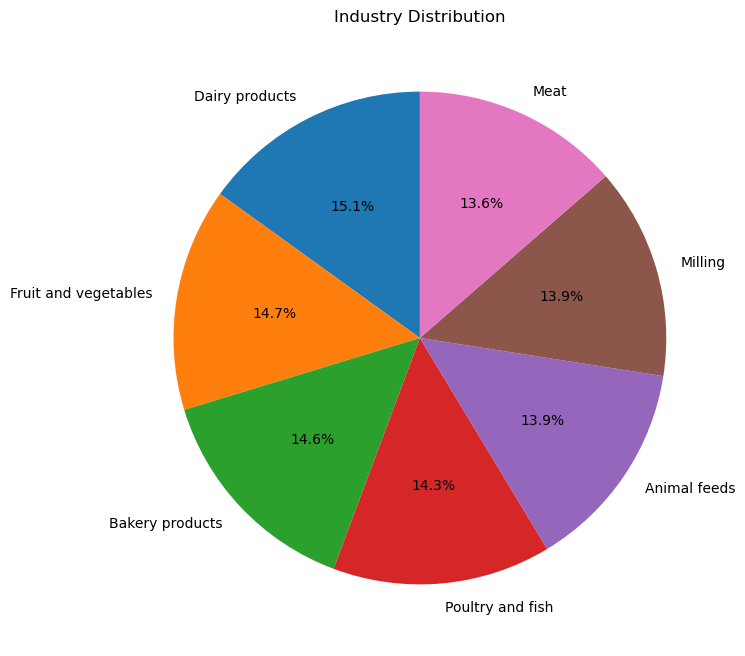

In [24]:
plt.figure(figsize=(8, 8))
data_graphics['Industry'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Total Industry Distribution')
plt.ylabel('')
plt.show()

In [41]:
# Calculate the percentage distribution of contacts by city
city_distribution = data_graphics['city'].value_counts(normalize=True) * 100

# Identify cities with less than 9% and group them into 'Others'
threshold = 9.4
filtered_cities = city_distribution[city_distribution >= threshold].index
data_graphics['city_grouped'] = data_graphics['city'].apply(lambda x: x if x in filtered_cities else 'Others')

# Create a pie chart to show the grouped distribution
fig = px.pie(data_graphics, names='city_grouped', title='Interactive Pie Chart: City Distribution')

# Show the plot
fig.show()

In [27]:
# Calculate the percentage distribution of contacts by country
country_distribution = data_graphics['country'].value_counts(normalize=True) * 100

# Identify countries with less than 9% and group them into 'Others'
threshold = 9
filtered_countries = country_distribution[country_distribution >= threshold].index
data_graphics['country_grouped'] = data_graphics['country'].apply(lambda x: x if x in filtered_countries else 'Others')

# Create a histogram to show the grouped distribution
fig = px.histogram(data_graphics, x='country_grouped', title='Interactive Histogram: Country Distribution (Grouped)',
                   labels={'country_grouped': 'Country Grouped', 'count': 'Count'})

# Customize layout
fig.update_layout(xaxis_title='Country Grouped', yaxis_title='Count')

# Show the plot
fig.show()


In [46]:
fig = px.sunburst(data_graphics, path=['country', 'Industry'], title='Sunburst Chart: Country and Industry Hierarchy')

# Adjust the size of the chart
fig.update_layout(width=800, height=600)

fig.show()


# Some Things to Improve

## Improvement Suggestions for possible functions users

### `countryCity()` Function

The current implementation of the `countryCity()` function lacks consideration for cities with the same name but belonging to different countries. For instance:

- Waterford, United Kingdom
- Waterford, United States

In the current version, the function may not accurately handle such cases. To improve it, consider implementing a more robust mechanism to distinguish cities with identical names based on their associated countries. This enhancement will lead to more accurate results when determining the country associated with a given city.

### `duplicatesManagement()` Function

The `duplicatesManagement()` function, as it stands, does not perform cross-record comparisons for merging information. In its current state, the function may not efficiently merge data from duplicate records. To enhance this function, consider implementing a more comprehensive logic that iterates through duplicate records, compares relevant information, and merges data accordingly. This improvement will ensure a more effective management of duplicate records, resulting in a more accurate and consolidated dataset.

### `uploadContacts()` Function

Currently this function uploads one by one registers but, HubSpot is capable to receive 100 registers at once time. It could be a great improvement in this ETL pipeline.

# References

### Data Sources

The following repositories were used as data sources in the ETL Pipeline:

1. **Country Codes Dataset**
   - Repository: [datasets/country-codes](https://github.com/datasets/country-codes)
   - Dataset File: [country-codes.csv](https://github.com/datasets/country-codes/blob/master/data/country-codes.csv)

2. **Countries, States, and Cities Database**
   - Repository: [dr5hn/countries-states-cities-database](https://github.com/dr5hn/countries-states-cities-database)
   - Dataset File: [cities.csv](https://github.com/dr5hn/countries-states-cities-database/blob/master/csv/cities.csv)

These repositories provided essential data for the ETL process, contributing to the transformation process of contact information in the HubSpot CRM.
